<a href="https://colab.research.google.com/github/rsudiplive/US-Airline_tweet_sentiment_analysis/blob/main/US_Airline_tweet_sentiment_analysis_DL_RNN_LSTM_arch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my continuation of the original problem statement for analyzing US-Airlines tweets sentiments.

The first part of the notebook contains extensive EDA, feature engineering, NLP/text-preprocessing. 
This notebook is majorly focused on Deep Learning by building a RNN-LSTM architecture to classify tweet sentiments and make predictions.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#train-test-split:
from sklearn.model_selection import train_test_split

#nlp:
import re, nltk
nltk.download('punkt')
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

#Deep Learning:
!pip install tensorflow
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The first few code blocks will be similar to the first part where we did variable exploration, data processing/cleaning.

In [40]:
#reading the dataset:
airline_df = pd.read_csv('/content/drive/MyDrive/AB_DS/datasets/Tweets.csv')
airline_df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [41]:
airline_df.shape

(14640, 15)

In [42]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## **Variables Exploration:**

The dataset contains 14640 no of observations with a total of 15 features. Few of the variables are having null values but we're not going to do any treatment for null values at the moment but we can do it at the later stage either by dropping them or imputing with any measures of central tendency or we can choose the important features for our model and treat them accordingly!

**airline_sentiment** is the target/dependent variables whereas **text** column qualifies as one of the independent variable while training and testing the model.


## **Data Exploration & Pre-processing!**

In [43]:
#no of unique values excluding null values!
airline_df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [44]:
#checking null values in our data
airline_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [45]:
missing_val_count_by_column = airline_df.isnull().sum()/len(airline_df)
#missing value count/cols having max null values
print(missing_val_count_by_column[missing_val_count_by_column > 0.4].sort_values(ascending=False))

negativereason_gold       0.997814
airline_sentiment_gold    0.997268
tweet_coord               0.930396
dtype: float64


We can remove the above three columns as they contain more than 90% of the missing values and hence won't contribute much to the model.

In [46]:
#dropping null values with a threshold set to 40%
airline_df = airline_df.dropna(thresh=airline_df.shape[0]*0.4,how='all',axis=1)
airline_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created', 'tweet_location',
       'user_timezone'],
      dtype='object')

In [47]:
#checking duplicate records!
print(f"There are {airline_df.duplicated().sum()} duplicate records in the datset.") 

There are 39 duplicate records in the datset.


In [48]:
#removing the duplicates!
airline_df.drop_duplicates(inplace = True)
print(f"There are now {airline_df.duplicated().sum()} duplicate records in the datset.")

There are now 0 duplicate records in the datset.


## **Deep Learning: Using RNN-LSTM architecture!**

**RNNs are used to capture the temporal dependencies in the input text**. **The most commonly used RNN architecture for text classification is the Long Short-Term Memory (LSTM) network**, which is designed to selectively remember or forget information from the input sequence. **LSTM networks have been shown to be effective for various text classification tasks, including sentiment analysis.**

Let us pre-process the data(text-preprocessing step) again:

In [50]:
# preprocess the data
def cleaned_text(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[1:]) #to take the words after @<airline-name> in the beginning of the texts!

def tweet_cleaned(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in set(stopwords.words('english'))])

In [51]:
#appying the data pre-processing steps:
airline_df['cleaned_tweet'] = airline_df['text'].apply(cleaned_text)
#for string punctuations and stopwords:
airline_df['cleaned_tweet'] = airline_df['cleaned_tweet'].apply(tweet_cleaned)
airline_df.reset_index(drop=True, inplace = True)
airline_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),dhepburn said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercials experience tacky
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),today must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing


In [52]:
airline_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created', 'tweet_location',
       'user_timezone', 'cleaned_tweet'],
      dtype='object')

In [55]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(airline_df['cleaned_tweet'], airline_df['airline_sentiment'], test_size=0.2, random_state=10)

In [56]:
# convert sentiment labels to categorical
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [57]:
# convert text to sequences:
max_features = 5000
# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
#fit_on_texts is used to create the dictionary by assigning 
#each unique word a unique integer index
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
#texts_to_sequences converts the texts into a sequence of integers, 
#where each integer corresponds to the index of the corresponding word in the dictionary.

In [58]:
vocab_size=5000
corpus = [text for text in airline_df['cleaned_tweet'].values if text]
max_sent_length=max([len(i) for i in corpus])

In [59]:
# pad sequences to make them equal length
X_train_seq = pad_sequences(X_train_seq,maxlen=max_sent_length,padding='post')
X_test_seq = pad_sequences(X_test_seq,maxlen=max_sent_length,padding='post')

### **Define the RNN model with LSTM architecture:**

In [60]:
import tensorflow as tf
from tensorflow.keras import regularizers

In [61]:
# Define the model architecture
embedding_vector_features = 40
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_vector_features, input_length=max_sent_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.2, recurrent_dropout = 0.2)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')])

In [62]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [63]:
# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)

In [64]:
# Train the model
history = model.fit(X_train_seq, y_train, batch_size=32, epochs=20, validation_data=(X_test_seq, y_test), callbacks=[early_stop, reduce_lr])

Epoch 1/20
365/365 [==============================] - 251s 674ms/step - loss: 0.8011 - accuracy: 0.7177 - val_loss: 0.6523 - val_accuracy: 0.7515 - lr: 0.0100
Epoch 2/20
365/365 [==============================] - 240s 658ms/step - loss: 0.5538 - accuracy: 0.8113 - val_loss: 0.6377 - val_accuracy: 0.7713 - lr: 0.0100
Epoch 3/20
365/365 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.8511
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
365/365 [==============================] - 239s 655ms/step - loss: 0.4705 - accuracy: 0.8511 - val_loss: 0.6510 - val_accuracy: 0.7788 - lr: 0.0100
Epoch 4/20
365/365 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8971
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
365/365 [==============================] - 236s 646ms/step - loss: 0.3217 - accuracy: 0.8971 - val_loss: 0.6768 - val_accuracy: 0.7778 - lr: 1.0000e-03
Epoch 5/20
365/365 [==================

In [65]:
# Find train and test accuracy
loss, accuracy = model.evaluate(X_train_seq, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_seq, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8525
Testing Accuracy:  0.7713


In [66]:
# Generate predictions
y_pred = model.predict(X_test_seq)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

92/92 [==============================] - 7s 74ms/step


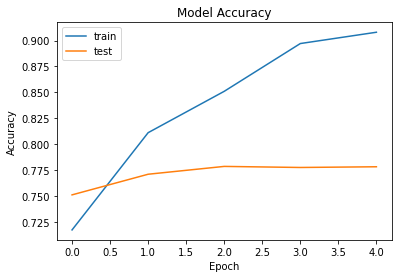

In [69]:
# Plot the accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Improvisations:**

We'll try with tuning some hyper-parameters, decreasing the model complexity by reducing the no of layers, adding more dropout layers, reducing the L2 regularization parameter, adding a SpatialDropout1D layer to prevent overfitting and increase the model's generalization ability.

In [70]:
# Tokenize the text data
vocab_size = 10000 #increased vocab size
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
X_seq = tokenizer.texts_to_sequences(X_train)
max_sent_length = max([len(x) for x in X_seq])
X_padded = pad_sequences(X_seq, maxlen=max_sent_length, padding='post')

In [71]:
X = airline_df['cleaned_tweet'].values
y = airline_df['airline_sentiment'].values

In [75]:
print(y) #we need to map this string labels to integer labels 

['neutral' 'positive' 'neutral' ... 'neutral' 'negative' 'neutral']


In [72]:
# Tokenize the text data
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
X_seq = tokenizer.texts_to_sequences(X)
max_sent_length = max([len(x) for x in X_seq])
X_padded = pad_sequences(X_seq, maxlen=max_sent_length, padding='post')

In [76]:
# Get the labels from the DataFrame and convert to integer labels
label_map = {"positive": 0, "negative": 1, "neutral": 2}
labels = [label_map[label] for label in y]

# Convert the integer labels to one-hot encoding
y_one_hot = tf.keras.utils.to_categorical(labels, num_classes=3)

In [84]:
# Define the model architecture
embedding_dim = 100
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sent_length, trainable=True),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])

In [85]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [86]:
# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)

In [87]:
# Train the model
history = model_lstm.fit(X_padded, y_one_hot, batch_size=32, epochs=20, validation_split=0.2, callbacks=[early_stop, reduce_lr])

Epoch 1/20
365/365 [==============================] - 60s 140ms/step - loss: 2.0394 - accuracy: 0.6509 - val_loss: 0.5844 - val_accuracy: 0.7795 - lr: 0.0010
Epoch 2/20
365/365 [==============================] - 51s 139ms/step - loss: 0.5994 - accuracy: 0.7713 - val_loss: 0.5632 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 3/20
365/365 [==============================] - 51s 139ms/step - loss: 0.4702 - accuracy: 0.8432 - val_loss: 0.5463 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 4/20
365/365 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8849
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
365/365 [==============================] - 50s 137ms/step - loss: 0.3746 - accuracy: 0.8849 - val_loss: 0.5639 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 5/20
365/365 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.9247
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
365/365 [========================

In [89]:
# Evaluate the model
test_loss, test_acc = model_lstm.evaluate(X_padded, y_one_hot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

457/457 [==============================] - 10s 22ms/step - loss: 0.3785 - accuracy: 0.8829
Test Loss: 0.3785141110420227
Test Accuracy: 0.8828847408294678


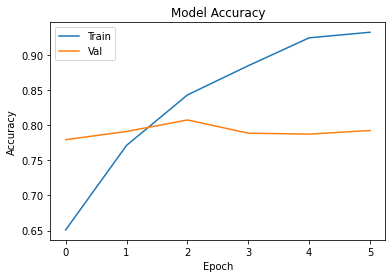

In [90]:
# Plot the learning curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

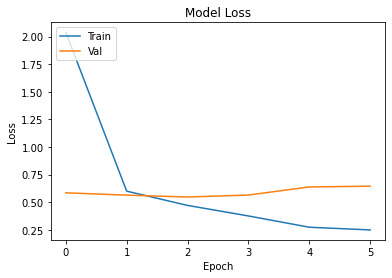

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Here we're getting a test score of 0.37 and testing accuracy of 0.88(88%) which is higher than the first level of architecture. A test accuracy of 88% is relatively good for a sentiment analysis task using an RNN-LSTM model.

But, looking at the learning curves there's some overfitting happening and due to time constraints, its very difficult to try and test with every possibilities. 

We can definitely play around with improving the model performance and reducing the overfitting problem by using pre-trained embeddings like Glove, experimenting with other activation functions like leaky Relu or sigmoid, or adding more LSTM layers or increasing the number of neurons in the existing LSTM layer to capture more complex temporal patterns in the tweet sequences,also experimenting with different dropout rates, learning rates, and regularization values to see if they improve the model's performance and prevent overfitting. 

Additionaly, we can try using more advanced architectures such as GRUs or transformers to see if it improves the model's performance.

I hope you liked it. I have tried my best in explaining or implementing different methods/techniques while dealing with such problem statement. Although due to lack of time & computing power/resources like GPU, I've emphasized majorly on what can be done at my end but still it took a lot of time to fine-tune, changing hyperparameters and techniques to achieve good model performance.


Please show some support by adding a star to this repository..
Thanks!

In [ ]:
#This notebook is contributed by Sudip Roy :)